In [46]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# For reproducibility
tf.keras.utils.set_random_seed(42)

# Set Training and Validation Datasets

### Directories

In [84]:
train_directory = '../../Data/Train/'
validation_directory = '../../Data/Validation/'

### Image Shapes

In [85]:
img = img_to_array(load_img(train_directory + 'Fake/Fake_10.jpg'))

w = img.shape[0]
h = img.shape[1]

In [44]:
train_ds = image_dataset_from_directory(
    directory=train_directory,
    image_size=(w, h),
    batch_size=64,
    seed=42,
    label_mode='binary',
)

val_ds = image_dataset_from_directory(
    directory=validation_directory,
    image_size=(w, h),
    batch_size=64,
    seed=42,
    label_mode='binary',
)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


# EfficientnetV2B0 Model

In [47]:
model = Sequential()

effnet_V2L = EfficientNetV2B0(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    pooling='max',
    classes = 2,
    include_preprocessing=True     #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L.trainable = True

model.add(effnet_V2L)

model.add(Dense(1, activation='sigmoid'))

24289280/24274472 [==============================] - 1s 0us/step


In [48]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [49]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='bce',
    metrics=['acc']
)

In [50]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-05-18 17:28:48.608097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8872

2023-05-18 18:28:05.681589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 3784s 2s/step - loss: 0.3019 - acc: 0.8872 - val_loss: 0.2602 - val_acc: 0.9033
Epoch 2/10
2188/2188 [==============================] - 3909s 2s/step - loss: 0.1009 - acc: 0.9617 - val_loss: 0.1820 - val_acc: 0.9311
Epoch 3/10
2188/2188 [==============================] - 3566s 2s/step - loss: 0.0610 - acc: 0.9765 - val_loss: 0.1432 - val_acc: 0.9465
Epoch 4/10
2188/2188 [==============================] - 3557s 2s/step - loss: 0.0392 - acc: 0.9851 - val_loss: 0.1265 - val_acc: 0.9544
Epoch 5/10
2188/2188 [==============================] - 3501s 2s/step - loss: 0.0252 - acc: 0.9910 - val_loss: 0.1173 - val_acc: 0.9590
Epoch 6/10
2188/2188 [==============================] - 3449s 2s/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.1168 - val_acc: 0.9614
Epoch 7/10
2188/2188 [==============================] - 3435s 2s/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.1092 - val_acc: 0.9649
Epoch 8/10
2188/2188 [==============================] - 358

In [86]:
import sys
sys.path.append("..")
 
import Helper.config as hf

### Plot Comparative Metrics

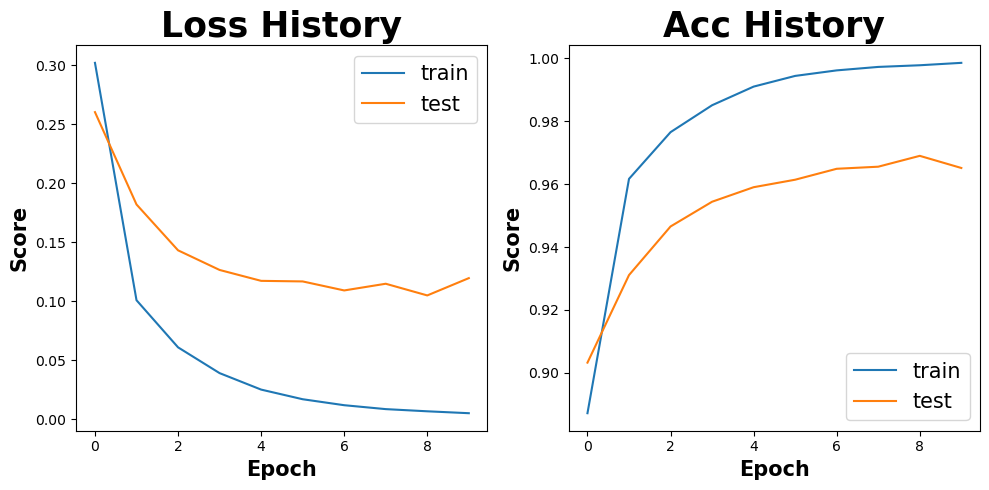

In [87]:
hf.graph_me(history, ['acc'])

# CNN Model

In [88]:
# Reduced complexity and added normalization and dropout to an approach taken here, based on a theory that it would improve performance 
# https://www.kaggle.com/code/slimreaper/inceptionv3-88-classification

cnn_model = Sequential()

cnn_model.add(Rescaling(1./255, input_shape=(h,w,3)))

cnn_model.add(Conv2D(16, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(32, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(1, activation='sigmoid'))

In [180]:
cnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

In [181]:
cnn_model.compile(optimizer='adam',
                  loss='bce',
                  metrics='acc'
                 )

In [ ]:
cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)